## **Train Pipeline**
This notebook will be used to train the CNN based network for the MNIST dataset.

In [1]:
import sys
sys.path.append("/home/jupyter-iroy2/advanced-neural-networks")

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from tqdm import tqdm

import advanced_neural_networks
from advanced_neural_networks.dataloader.mnist import MNISTDataset
from advanced_neural_networks.models.simple_convnet import SimpleConvNet

2024-01-18 23:36:57.914941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 23:36:57.914985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 23:36:57.915867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 23:36:57.921966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 23:36:58.875380: W tensorflow/compiler/tf2

In [3]:
module_dir = advanced_neural_networks.__path__[0]
dataloader_path = os.path.join(module_dir, "dataloader")
dataset_config = os.path.join(dataloader_path, "mnist_config.yaml")

In [4]:
## load dataset
mnist_train = MNISTDataset(config_file = dataset_config,
                          location = "cloud",
                          train = True,
                          transforms = [])

mnist_val = MNISTDataset(config_file = dataset_config,
                          location = "cloud",
                          train = False,
                          transforms = [])

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size = batch_size, shuffle = False)

In [5]:
## initialize model, loss function and optimizer

learning_rate = 0.001
momentum = 0.9

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleConvNet().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)


In [8]:
def train_one_epoch(epoch_idx: int,
                    tb_writer: SummaryWriter):
    running_loss = 0.0
    last_loss = 0.0
    x_corrupt = None
    y_hat_corrupt = None

    for i, data in enumerate(train_dataloader):
        x_inputs, y = data
        y = y.squeeze() 
        x_inputs, y = x_inputs.to(device), y.to(device)
        #zero out the gradients
        optimizer.zero_grad()

        # make predictions
        y_hat = model(x_inputs)        
        loss = criterion(y, y_hat)
        if np.isnan(loss.item()):
            x_corrupt = x_inputs
            y_hat_corrupt = y_hat
            break
        loss.backward()
        

        optimizer.step()
        running_loss += loss.item()

        if i % 1000 == 0:
            last_loss = running_loss / 1000
            # print(f"Epoch: {epoch_idx + 1}, loss: {last_loss}")
            tensorboard_idx = epoch_idx * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tensorboard_idx)
            running_loss = 0.0

    return last_loss, x_corrupt, y_hat_corrupt

In [9]:
## Main Training loop
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/mnist_trainer_simpleconvnet{}'.format(timestamp))
epoch_number = 0

n_epochs = 20
best_vloss = 1_000_000.

train_loss = []
val_loss = []

for epoch in tqdm(range(n_epochs)):
    model.train(True)
    avg_loss, x_corrupt, y_hat_corrupt = train_one_epoch(epoch, writer)

    running_val_loss = 0.0
    model.eval()

    with torch.no_grad():
        for itr, val_data in enumerate(val_dataloader):
            val_x, val_y = val_data
            val_y = val_y.squeeze()
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_y_hat = model(val_x)
            loss = criterion(val_y_hat, val_y)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / (itr + 1)
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_val_loss },
                    epoch + 1)
    writer.flush()

    if avg_val_loss < best_vloss:
        best_vloss = avg_val_loss

    train_loss.append(avg_loss)
    val_loss.append(avg_val_loss)

    

100%|██████████| 20/20 [14:09<00:00, 42.50s/it]


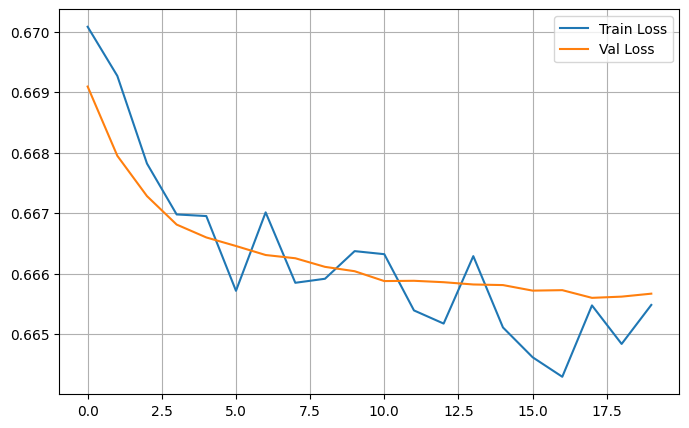

In [11]:
plt.figure(figsize = (8, 5))
plt.plot(np.arange(20), train_loss, label = "Train Loss")
plt.plot(np.arange(20), val_loss, label = "Val Loss")
plt.grid()
plt.legend()
plt.show()